In [1]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [2]:
base_path = '/home/sanjeev/ML_Dataset/microsoft_dataset/asm_img/'# Data Path 
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [3]:
# classes in malimg data
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [4]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(
    [f for f in os.listdir(os.getcwd()) if not f.startswith('.')], 
    key=str.lower
)
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


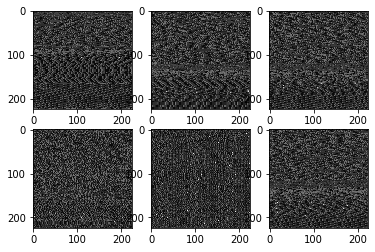

In [5]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [6]:
#loading labels
labels = np.load("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/features/labels.npy")
labels.shape

(10868,)

In [7]:
asm_features=np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/features/MobileNetV3_Large_feat_asm_microsoft_4096.npy')
bytes_features=np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/features/MobileNetV3_Large_feat_bytes_microsoft_4096.npy')

In [8]:
X = []
for i in range(len(asm_features)):
    x = list(np.hstack((asm_features[i], bytes_features[i])))
    X.append(x)
X =  np.array(X)
X.shape

(10868, 8192)

In [9]:
import pandas as pd
import disarray as da
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef, roc_curve, auc

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.21, random_state=42)

In [11]:
print("X_Train:", X_train.shape)
print("Y_Train:", y_train.shape)
print("X_Test:", X_test.shape)
print("Y_Test:", y_test.shape)

X_Train: (8585, 8192)
Y_Train: (8585,)
X_Test: (2283, 8192)
Y_Test: (2283,)


In [12]:
%%time
clf = MLPClassifier(random_state=31, max_iter=700)

CPU times: user 66 µs, sys: 35 µs, total: 101 µs
Wall time: 129 µs


In [13]:
%%time
clf.fit(X_train,y_train)

CPU times: user 2h 45min 31s, sys: 2h 44min 27s, total: 5h 29min 58s
Wall time: 5min 11s


MLPClassifier(max_iter=700, random_state=31)

In [14]:
print("Testing Accuracy:", round((clf.score(X_test, y_test) * 100), 2))

Testing Accuracy: 93.08


In [15]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 2.41 s, sys: 1.93 s, total: 4.34 s
Wall time: 68.4 ms


In [16]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

93 93 93
CPU times: user 320 ms, sys: 372 ms, total: 692 ms
Wall time: 11 ms


In [17]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       218
         1.0       0.85      1.00      0.92        69
         2.0       0.99      0.99      0.99       626
         3.0       0.96      0.89      0.92       544
         4.0       0.93      0.85      0.89       269
         5.0       0.88      0.96      0.92       305
         6.0       0.29      1.00      0.44         2
         7.0       0.85      0.86      0.85       153
         8.0       0.71      0.81      0.76        97

    accuracy                           0.93      2283
   macro avg       0.83      0.93      0.85      2283
weighted avg       0.94      0.93      0.93      2283



In [18]:
# GridSearchCV

In [19]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

CPU times: user 594 µs, sys: 596 µs, total: 1.19 ms
Wall time: 34.8 µs


In [20]:
%%time
gs = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=5)
gs.fit(X_train, y_train)

CPU times: user 1h 26min 19s, sys: 1h 24min 1s, total: 2h 50min 20s
Wall time: 17min 47s


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=700, random_state=31),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [21]:
print("Best hyperparameters:", gs.best_params_)

Best hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


In [22]:
# to be added in remaining code

print("Accuracy on testing set: {:.3f}".format(gs.score(X_test, y_test)))

Accuracy on testing set: 0.935


In [23]:
y_pred = gs.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       219
         1.0       0.97      0.89      0.93        81
         2.0       0.99      0.99      0.99       624
         3.0       0.91      0.94      0.92       507
         4.0       0.90      0.92      0.91       245
         5.0       0.95      0.92      0.94       332
         6.0       0.75      0.43      0.55         7
         7.0       0.82      0.88      0.85       156
         8.0       0.80      0.69      0.74       112

    accuracy                           0.94      2283
   macro avg       0.90      0.85      0.87      2283
weighted avg       0.93      0.94      0.93      2283



In [24]:
list_fams = sorted(label_dict.keys())

In [25]:
list_fams = [f for f in list_fams if not f.startswith('.')]

In [26]:
classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/4096/plots/MobileNetV3_large_MLP_st_8192.csv')

Plotting the confusion matrix


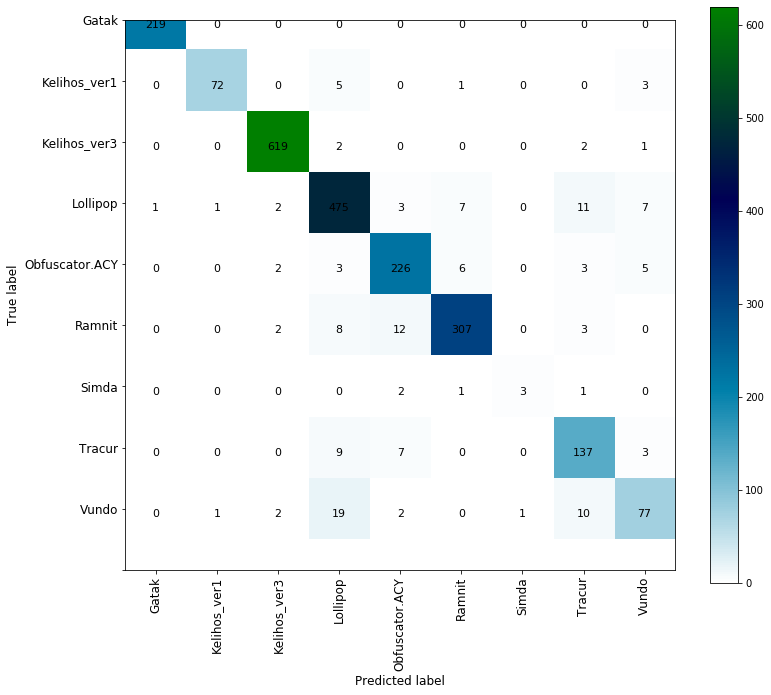

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=11)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.tight_layout()
plt.colorbar()
plt.savefig('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/4096/plots//MobileNetV3_large_MLP_st_8192.eps', bbox_inches='tight')
plt.savefig('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/4096/plots//MobileNetV3_large_MLP_st_8192.png', bbox_inches='tight')

plt.show()

In [28]:
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm)

In [29]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [30]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [31]:
FP, FN, TP, TN

(array([ 1,  2,  8, 46, 26, 15,  1, 30, 19]),
 array([ 0,  9,  5, 32, 19, 25,  4, 19, 35]),
 array([219,  72, 619, 475, 226, 307,   3, 137,  77]),
 array([2063, 2200, 1651, 1730, 2012, 1936, 2275, 2097, 2152]))

In [32]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.        , 0.00407424, 0.00301932, 0.01816118, 0.009355  ,
       0.0127486 , 0.00175516, 0.00897921, 0.01600366])

In [33]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [34]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,1.000000,0.999516,0.000484,0.000000,0.004545,0.000000
Kelihos_ver1,0.888889,0.999092,0.000908,0.111111,0.027027,0.004074
Kelihos_ver3,0.991987,0.995178,0.004822,0.008013,0.012759,0.003019
Lollipop,0.936884,0.974099,0.025901,0.063116,0.088292,0.018161
Obfuscator.ACY,0.922449,0.987242,0.012758,0.077551,0.103175,0.009355
Ramnit,0.924699,0.992312,0.007688,0.075301,0.046584,0.012749
Simda,0.428571,0.999561,0.000439,0.571429,0.250000,0.001755
Tracur,0.878205,0.985896,0.014104,0.121795,0.179641,0.008979
Vundo,0.687500,0.991248,0.008752,0.312500,0.197917,0.016004


In [35]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 85.102
Average of true_negative_rate --> 99.1571
Average of false_positive_rate --> 0.8429
Average of false_negative_rate --> 14.898
Average of false_discovery_rate --> 10.1104
Average of false_omission_rate --> 0.8233


In [36]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_test, y_pred), 2))

MCC Score: 0.92


In [37]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.9351730179588261
micro_recall : 0.9351730179588261
micro_f1_score : 0.9351730179588261


In [38]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.8988956401996351
macro_recall : 0.8510204476796118
macro_f1_score : 0.869213135121989


In [39]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [40]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [41]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

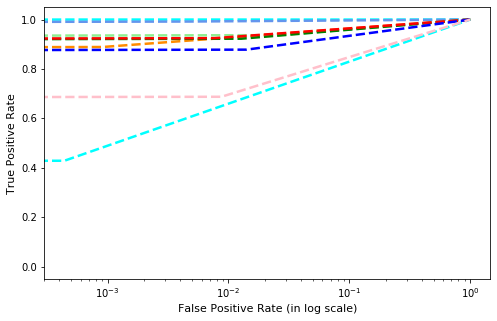

In [42]:
# Compute macro-average ROC curve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.savefig("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/4096/plots/MobileNetV3_large_MLP_st_8192.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/4096/plots/MobileNetV3_large_MLP_st_8192.png", bbox_inches='tight')

plt.show()